<a href="https://colab.research.google.com/github/khotimnr/SentiStrengthID/blob/master/Sentiment_Analysis_(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modul 3: Sentiment Analysis
Sentiment Analysis adalah proses melakukan identifikasi dan ekstrak informasi dari data teks untuk mengetahui sentimen dari produk yang bisa berupa positif, negatif, atau netral. Berikut ini adalah contohnya dari review film Spider-Man: Into the Spider-Verse:

* positif: "Keren banget animasinya, film animasi terbaik yang pernah saya tonton!"
* negatif: "Biasa aja gak ada seru-serunya, alur ceritanya jelek."
* netral: "Pertamax gan!"

## Step 1: Explore Data
Dataset yang digunakan adalah data hasil crawling dari Bukalapak, yang setiap datanya sudah terdapat column rate dari 1-5.

In [0]:
# lakukan load dataset terlebih dahulu
import pandas as pd

df_review = pd.read_csv("review.csv")
df_review.head()

,Name,Date,Comment,Star
0,Okky Pratiwi,06-08-2019,Bisa tahu ongkir sebelum beli adalah kenikmata...,5
1,Iwan Kurniawan,06-08-2019,Nice olshop,5
2,hermawan sanjaya,06-08-2019,"Penggunaan mudah, simpel, gak banyak flash yg ...",5
3,mitra yunedi,06-08-2019,Applikasi beefungsi dg baik dan lancar terimak...,5
4,NewRule W,06-08-2019,kenapa skrg lemot sih respon pelanggan,1


In [0]:
# coba kita perhatikan berapa banyak data yang kita dapatkan
df_review.describe()

,Star
count,63320.000000
mean,3.962066
std,1.573255
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [0]:
# coba kita lihat salah satu hasil review
df_review["Comment"][3]

'Applikasi beefungsi dg baik dan lancar terimakasih Bukalapak'

Salah satu tantangan dalam data kita kali ini adalah banyak bahasa yang tidak lengkap dan tidak baku.

In [0]:
# coba kita lihat berapa banyak jumlah data untuk tiap rate
df_review["Star"].value_counts()

5    40606
1    11188
4     5118
3     3372
2     3036
Name: Star, dtype: int64

In [0]:
# coba kita lihat user unik yang ada
df_review["Name"].value_counts()[:10]

A Google user      5516
Muhammad Iqbal       15
Taufik Hidayat       10
Miftahul Jannah       7
Agung Prasetyo        7
Firman Syah           6
Agus Setiawan         6
Ahmad Fauzi           6
Budi Santoso          6
Iwan Setiawan         6
Name: Name, dtype: int64

In [0]:
# coba kita lihat user unik yang ada
df_review["Date"].value_counts()[:10]

23-05-2019    1469
24-04-2019     907
24-05-2019     878
25-04-2019     495
29-05-2019     465
28-05-2019     460
25-05-2019     448
30-05-2019     395
21-01-2019     390
26-04-2019     387
Name: Date, dtype: int64

In [0]:
# coba kita lihat user dengan nama Iwan Setiawan, komentar apa yang dia kemukakan
df_review[df_review["Name"] == "Iwan Setiawan"]

,Name,Date,Comment,Star
2396,Iwan Setiawan,21-07-2019,"kadang sering eror dan loadingnya lama, lain l...",4
14059,Iwan Setiawan,10-05-2019,mudah.. dan terpercaya,5
18056,Iwan Setiawan,30-03-2019,good,5
21504,Iwan Setiawan,04-03-2019,bukalapak mnurut saya buka dompet nya jangan d...,1
29453,Iwan Setiawan,25-11-2018,Nice app keep inovated,5
34118,Iwan Setiawan,28-08-2018,Nice,5


## Step 2: Preprocessing
Pada tahap ini tujuannya adalah mengubah dataset supaya dapat diolah pada algoritma Machine Learning. 

Pertama, kita akan mengubah menjadi 2 sentiment dulu, yaitu 'positif' dan 'negatif'.
* Untuk sentiment positif, adalah data dengan rate 5, menjadi label 1
* Untuk sentiment negatif, adalah data dengan rate 1-4, menjadi label 0

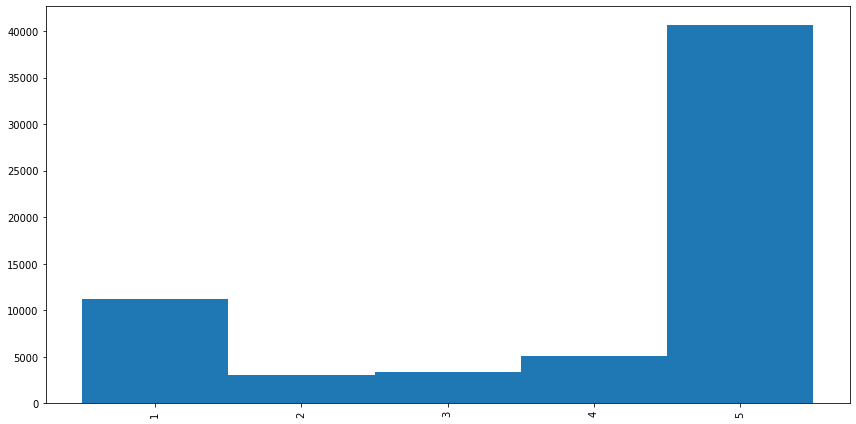

In [0]:
# kita lihat dulu distribusi label
import matplotlib.pyplot as plt

_, ax1 = plt.subplots(figsize=(12,6))

stars_histogram = df_review["Star"].value_counts().sort_index()

stars_histogram.plot(kind="bar", width=1.0)
plt.tight_layout()
plt.show()

In [0]:
# mengubah rate
label = []
for index, row in df_review.iterrows():
    if row["Star"] == 5:
        label.append(1)
    else:
        label.append(0)

df_review["label"] = label
df_review = df_review.drop(columns=['Star'])
df_review.tail()

,Name,Date,Comment,label
63315,dzaki rinaldi,11-08-2018,Gak bisa beli pulsa pakai shopeePay,0
63316,BlueSkiesBaby,11-08-2018,Gak bisa beli pulsa pake shopeePay,0
63317,A Google user,11-08-2018,Pelayanan dari pihak shopee sangat bagus dan c...,1
63318,Nisrina Amalia,11-08-2018,Masa abis diupgrade makin ga bisa masuk dong k...,0
63319,Pengguna Kartu Pra-kerja,11-08-2018,Tidak bisa mengisi alamat.. ketika memilih pro...,0


In [0]:
# cek lagi data
df_review['label'].value_counts()

1    40606
0    22714
Name: label, dtype: int64

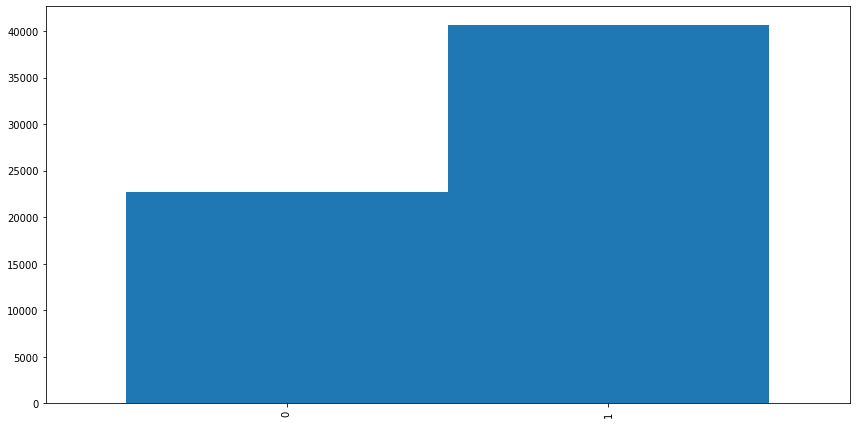

In [0]:
# kita lihat lagi distribusi label
import matplotlib.pyplot as plt

_, ax1 = plt.subplots(figsize=(12,6))

stars_histogram = df_review["label"].value_counts().sort_index()

stars_histogram.plot(kind="bar", width=1.0)
plt.tight_layout()
plt.show()

### Cleansing Data
Hapus tanda baca, lower text, dll.

In [0]:
import string, re

def cleansing(data):
    # lower text
    data = data.lower()
    
    # hapus punctuation
    remove = string.punctuation
    translator = str.maketrans(remove, ' '*len(remove))
    data = data.translate(translator)
    
    # remove ASCII dan unicode
    data = data.encode('ascii', 'ignore').decode('utf-8')
    data = re.sub(r'[^\x00-\x7f]',r'', data)
    
    # remove newline
    data = data.replace('\n', ' ')
    
    return data

In [0]:
# jalankan cleansing data
review = []
for index, row in df_review.iterrows():
    review.append(cleansing(row["Comment"]))
    
df_review["Comment"] = review
df_review.head()

,Name,Date,Comment,label
0,Okky Pratiwi,06-08-2019,bisa tahu ongkir sebelum beli adalah kenikmata...,1
1,Iwan Kurniawan,06-08-2019,nice olshop,1
2,hermawan sanjaya,06-08-2019,penggunaan mudah simpel gak banyak flash yg ...,1
3,mitra yunedi,06-08-2019,applikasi beefungsi dg baik dan lancar terimak...,1
4,NewRule W,06-08-2019,kenapa skrg lemot sih respon pelanggan,0


### Menghapus Stopwords
Berikutnya, kita akan menghapus stopwords menggunakan library Sastrawi. Stopwords adalah kata-kata yang tidak memiliki makna.

In [0]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 2.8MB/s 


In [0]:
# import library
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
 
# Contoh
kalimat = 'Dengan Menggunakan Python dan Library Sastrawi saya dapat melakukan proses Stopword Removal'
stop = stopword.remove(kalimat)
print(stop)

Dengan Menggunakan Python Library Sastrawi dapat melakukan proses Stopword Removal


In [0]:
# lakukan pada data kita

review = []
for index, row in df_review.iterrows():
    review.append(stopword.remove(row["Comment"]))
    
df_review["Comment"] = review
df_review.head()

,Name,Date,Comment,label
0,Okky Pratiwi,06-08-2019,tahu ongkir beli kenikmatan yg hakiki dlm berb...,1
1,Iwan Kurniawan,06-08-2019,nice olshop,1
2,hermawan sanjaya,06-08-2019,penggunaan mudah simpel gak banyak flash yg ...,1
3,mitra yunedi,06-08-2019,applikasi beefungsi dg baik lancar terimakasih...,1
4,NewRule W,06-08-2019,skrg lemot sih respon pelanggan,0


### Melakukan Stemming

In [0]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# contoh
kalimat = 'Valentino Rossi tampak sangat menyesal setelah terjatuh pada lap terakhir MotoGP Prancis 2017'
katadasar = stemmer.stem(kalimat)
 
print(katadasar)

valentino rossi tampak sangat sesal telah jatuh pada lap akhir motogp prancis 2017


In [0]:
# implementasi pada data kita
review = []
for index, row in df_review.iterrows():
    review.append(stemmer.stem(row["Comment"]))
    
df_review["Comment"] = review
df_review.head()

,Name,Date,Comment,label
0,Okky Pratiwi,06-08-2019,tahu ongkir beli nikmat yg hakiki dlm belanja ...,1
1,Iwan Kurniawan,06-08-2019,nice olshop,1
2,hermawan sanjaya,06-08-2019,guna mudah simpel gak banyak flash yg bikin lot,1
3,mitra yunedi,06-08-2019,applikasi beefungsi dg baik lancar terimakasih...,1
4,NewRule W,06-08-2019,skrg lot sih respon langgan,0


In [0]:
# sekarang coba kita cek frekuensi kemunculan untuk tiap kata

### Drop Column Dataframe Tidak dipakai

In [0]:
df_preprocessed = df_review.copy()
df_preprocessed = df_preprocessed.drop(columns=['Date', 'Name'])
df_preprocessed.head()

,Comment,label
0,tahu ongkir beli nikmat yg hakiki dlm belanja ...,1
1,nice olshop,1
2,guna mudah simpel gak banyak flash yg bikin lot,1
3,applikasi beefungsi dg baik lancar terimakasih...,1
4,skrg lot sih respon langgan,0


### Bagi menjadi data train dan data test

In [0]:
# install sklearn terlebih dahulu jika belum terinstall, dengan pip install sklearn

In [0]:
!pip install sklearn

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_preprocessed, test_size=0.3, random_state=1)

In [0]:
# lihatlah perbandingannya untuk data train pada sentiment positive dan negative
print(train['label'].value_counts(normalize=True))

1    0.641684
0    0.358316
Name: label, dtype: float64


Karena jumlah review sentiment positive dan negative tidak seimbang pada data training, kita akan buat dataset menjadi seimbang dengan bootstraping.

In [0]:
# bootstrap
t_1 = train[train['label']==0].sample(2000,replace=True)
t_2 = train[train['label']==1].sample(2000,replace=True)
training_bs = pd.concat([t_1, t_2])

print(train.shape)
print(training_bs.shape)
print(test.shape)

# sanity check 
df_review.shape[0] == (train.shape[0] + test.shape[0])

(44324, 2)
(4000, 2)
(18996, 2)


True

In [0]:
print(training_bs['label'].value_counts(normalize=True))

1    0.5
0    0.5
Name: label, dtype: float64


In [0]:
training_bs.head()

,Comment,label
62646,eror skr 4 sept 2018 kok skr sering eror gmn n...,0
51634,cukup puas susah banget mau aktifin shopeepay ...,0
62692,yaaa masa tiba tiba logout hngg bener aja 2x k...,0
59102,ga login,0
36947,smpt masalah kembali dana tp syukurla uang sdh...,0


In [0]:
# install terlebih dahulu dengan pip install wordcloud

In [0]:
!pip install wordcloud

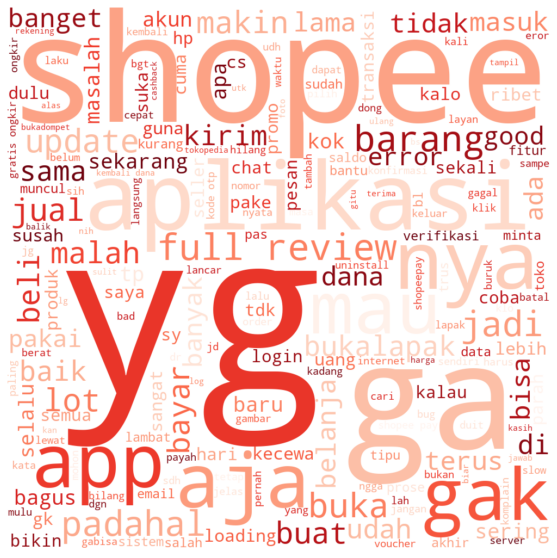

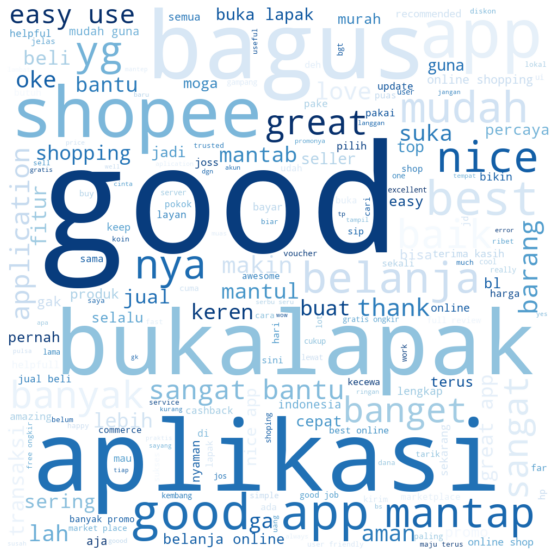

In [0]:
# wordcloud
from wordcloud import WordCloud

# Polarity == 0 negative
train_s0 = training_bs[training_bs["label"] == 0]
all_text_s0 = ' '.join(word for word in train_s0["Comment"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Polarity == 1 positive
train_s1 = training_bs[training_bs["label"] == 1]
all_text_s1 = ' '.join(word for word in train_s1["Comment"])
wordcloud = WordCloud(width=1000, height=1000, colormap='Blues', background_color='white', mode='RGBA').generate(all_text_s1)
plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [0]:
# kita juga bisa cek top 20 kata untuk masing-masing sentiment
from collections import Counter

counter_s0 = Counter(all_text_s0.split()).most_common(50)
counter_s1 = Counter(all_text_s1.split()).most_common(50)
print(counter_s0)
print()
print(counter_s1)

[('shopee', 348), ('yg', 320), ('aplikasi', 320), ('ga', 301), ('nya', 236), ('mau', 227), ('barang', 212), ('aja', 192), ('buka', 175), ('padahal', 172), ('gak', 167), ('jadi', 166), ('update', 163), ('review', 163), ('beli', 162), ('full', 162), ('app', 161), ('lama', 147), ('makin', 140), ('baik', 139), ('error', 138), ('lot', 136), ('sama', 131), ('dana', 128), ('belanja', 128), ('i', 128), ('sering', 126), ('terus', 124), ('jual', 123), ('bayar', 122), ('malah', 122), ('banget', 120), ('good', 112), ('kirim', 108), ('buat', 108), ('banyak', 105), ('udah', 104), ('bisa', 102), ('masalah', 101), ('to', 99), ('bukalapak', 99), ('hari', 98), ('di', 95), ('susah', 94), ('kode', 94), ('baru', 93), ('cs', 92), ('masuk', 92), ('akun', 91), ('loading', 91)]

[('good', 452), ('app', 160), ('aplikasi', 112), ('bagus', 101), ('bukalapak', 93), ('shopee', 91), ('belanja', 89), ('best', 85), ('sangat', 84), ('nice', 81), ('online', 76), ('mudah', 76), ('the', 71), ('very', 70), ('to', 67), ('gr

### Feature Extraction
Feature extraction merupakan sebuah step untuk mentransformasi teks kedalam angka atau yang bisa disebut feature representation. Terdapat beragam teknik untuk merubah teks kedalam array, tapi pada dasarnya kata kata unik dalam corpus itu yang menjadi featurenya. Feature extraction yang umum digunakan dalam sklearn adalah Count Vectorizer dan TF-IDF.


Count Vectorizer ini mudahnya menghitung semua kejadian kata dalam satu dokumen sedangkan tf-idf memberikan bobot masing masing kata.

In [0]:
# install terlebih dahulu sklearn dengan pip install sklearn

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    'Pusing satu kali',
    'Pusing dua kali',
    'Pusing tiga kali',
    'Pusing lagi']

vectorizer = CountVectorizer()

# contoh
X = vectorizer.fit_transform(corpus)
X.toarray()

array([[0, 1, 0, 1, 1, 0],
       [1, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0]])

In [0]:
# implementasi pada dokumen kita
X_train = vectorizer.fit_transform(training_bs["Comment"])
X_test = vectorizer.transform(test["Comment"])

print(X_train.shape)
print(X_test.shape)

(4000, 4755)
(18996, 4755)


### Wrapping All Preprocessing

In [0]:
def preprocess_data(data):
    # cleansing data
    data = cleansing(data)
    
    # hapus stopwords
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    data = stopword.remove(data)
    
    # stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)
    
    # count vectorizer
    data = vectorizer.transform([data])
    
    return data

# Training
Pada algoritma Machine Learning yang digunakan adalah Naive Bayes Classifier.

Naive Bayes classifier merupakan sebuh metode klasifikasi dengan probabilitas sederhana yang mengaplikasikan teorema Bayes dengan tidak ketergantungan (independen) yang tinggi.Model klasifikasi naive Bayes menghitung probabilitas posterior suatu kelas, berdasarkan pada distribusi kata-kata dalam dokumen. Klasifikasi naive Bayes dibangun oleh data pelatihan untuk memperkirakan probabilitas dari setiap kategori yang terdapat pada ciri dokumen yang diuji. Sistem akan dilatih dengan menggunakan data baru (data latih dan data uji) dan selanjutnya diberi tugas untuk menebak nilai fungsi target dari data tersebut.

In [0]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

clf.fit(X_train, training_bs['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Evaluation
Dalam metode Evaluation menggunakan Confusion Matrix. Confusion matrix adalah matrix yang merepresentasikan hasil klasifikasi biner pada suatu dataset. Terdapat beberapa rumus umum yang dapat digunakan untuk menghitung performa klasifikasi. Hasil dari nilai accuracy, precision dan recall bisa ditampilkan dalam persentase.

\begin{equation*}
Precision | Accuracy = \frac{TP}{(TP + FP)}.
\end{equation*}

\begin{equation*}
Recall|Sensitivity|True Positive Rate = \frac{TP}{(TP + FN)}.
\end{equation*}

- **TP:** true positive
- **FP:** false positive
- **FN:** false negative


It is convenient to combine precision and recall into a single metric called *F1 score.*

\begin{equation*}
F_1 = \frac{TP}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}.
\end{equation*}

In [0]:
# lakukan prediksi pada data test
predict = clf.predict(X_test)

In [0]:
# import library evaluation
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

In [0]:
# f1_score
f1_score(test['label'], predict)

0.8279776458260566

In [0]:
# precision score
precision_score(test['label'], predict)

0.8828677839851025

In [0]:
# recall score
recall_score(test['label'], predict)

0.7795133179875041

In [0]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(test['label'], predict).ravel()
tn, fp, fn, tp

(5574, 1258, 2682, 9482)

Kita coba lakukan prediksi sentiment pada suatu data baru yang kita buat sendiri.

In [0]:
review_positif = "barangnya bagus banget"
review_negatif = "barang jelek pelayanan"

Pda hasil, jika menghasilkan 1, maka reviewnya adalah positif. Sebalinyak jika menghasilkan 0, maka reviewnya adalah negatif.

In [0]:
clf.predict(preprocess_data(review_positif))

array([1])

In [0]:
clf.predict(preprocess_data(review_negatif))

array([0])